In [ ]:
# %pip install pytesseract
# %pip install opencv-python

In [117]:
from scipy import stats
from highlight_text import fig_text
from mplsoccer import PyPizza, add_image, FontManager

import re
import math
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt

import os
import pprint

# %matplotlib ipympl
# %matplotlib widget

In [5]:
# convert data file to dataframe
filepath = 'fm24-data/data/v3/top6_leagues_rb.html'

dfs = pd.read_html(filepath, encoding='utf8')
assert len(dfs) > 0 
df = dfs[0]

display(df.head())
print("Number of players:", df.shape[0])
print("Number of fields: ", df.shape[1])

,Rec,Inf,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Best Pos,...,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Dist/90,Distance,Gl Mst,Tgls/90,Tcon/90,Av Rat
0,- - A+ -,Ask,Robert,24,81 kg,186 cm,ESP,Left,D (RLC),D (L),...,0.26,10.56,3.03,17.47,0.0mi,162.2mi,0,3.56,2.74,7.10
1,- - A+ -,NaN,Runar Helle Hildre,24,71 kg,172 cm,NOR,Right,"D (RL), WB (R)",D (R),...,0.11,10.16,2.81,13.02,0.0mi,151.7mi,0,3.99,2.67,6.99
2,- - A+ -,NaN,Nick Broers,24,74 kg,179 cm,NED,Right,D/WB (R),D (R),...,0.05,7.15,2.54,15.26,0.0mi,166.5mi,1,6.34,1.66,7.00
3,- - A+ -,NaN,Genar Fortet,22,75 kg,181 cm,ESP,Right,"D (RL), WB/M/AM (R)",M (R),...,0.00,5.90,2.46,9.34,0.0mi,15.2mi,0,2.94,0.97,6.88
4,- - A+ -,NaN,Bruno Ferreirinha,22,87 kg,193 cm,POR,Right,D (RLC),D (R),...,0.67,2.91,0.90,6.38,0.0mi,130.2mi,0,6.35,1.69,7.04


Number of players: 797
Number of fields:  62


# Data Context

This section provides context for the player data exported from FM24. When calculating percentiles for player statistics, it's crucial to correctly select the player pool, primarily based on positions. According to FBref standards, there are six major position groups: Goalkeepers, Centerbacks, Fullbacks, Midfielders, Attacking Midfielders/Wingers, and Forwards. Recreating these categories with FM data poses a challenge. While we know the total minutes a player has played, FM24 doesn’t provide a way to export the approximate minutes played in specific positions.

As a result, we will group players based on the positions they are "able to play," rather than the positions they actually play. This introduces another issue: in FM, players have varying levels of familiarity with a position — categorized as "Competent," "Accomplished," and "Natural." Positions where a player is either "Competent," "Accomplished," or "Natural" will all appear in the "Position" column of the exported data, but there is no way to differentiate between these levels of familiarity for each position.

To address this, I opted to use the in-game filter to ensure that only players who are "Natural" in a specific position are included in the player pool for scouting.

# Data Processing



In [6]:
# make copy of dataframe
players = df.copy()

# 'Rec' and 'Info' are not useful
# 'Dist/90' are not exported correctly by FM24 (all zeros)
players = players.drop(['Rec', 'Inf', 'Dist/90'], axis=1)

column_types = {
    'integer': ['Age', 'Mins', 'Gls', 'Ast'],
    'percent': ['Shot %', 'Conv %', 'Pas %', 'OP-Cr %', 'Tck R', 'Hdr %'], 
    'categorical': ['Name', 'Position', 'Club', 'Division', 'Nat', 'Preferred Foot', 'Salary', 'Transfer Value'],
}

# Replace missing stats with 0s
# Note: in Football Manager - ~ 0
players = players.replace('-', 0)

# Transform weight, height columns
players['Weight'] = players['Weight'].str.split().str[0]
players['Height'] = players['Height'].str.split().str[0]

# Transform salary column
players['Salary'] = players['Salary'].str.extract(r'£([\d,]+)\s*p/w')[0]
players['Salary'] = players['Salary'].str.replace(',', '').astype(float)

# Transform transfer value
def transfer_value_regex_func(string):
    pattern = r'£(\d+\.*\d*[MK]*)'
    if (found := re.findall(pattern, string)):
        s = found[-1]
        if len(s) == 1:
            return 0
        val, unit = float(s[:-1]), s[-1] 
        if unit == 'M':
            val *= 1_000_000_000
        elif unit == 'K':
            val *= 1000
        return val
    elif string == 'Not for Sale':
        return float('inf')
    elif string == 'Unknown':
        return np.nan
    else:
        raise Exception('unknown format')

players['Transfer Value'] = players['Transfer Value'].apply(transfer_value_regex_func)

# Extract distance covered
players['Distance'] = players['Distance'].str.extract(r'([\d.]+)').astype(float)

# Convert % string to float
players[column_types['percent']] = players[column_types['percent']].apply(
    lambda x: pd.to_numeric(x.str.rstrip('%'), errors='coerce') / 100)

# TODO: improve this
# Replacing '-' with 0 causes data to be inconsistent in percent columns, i.e str "75%" and int 0
# We will set the NaNs resulting from the parsing to 0
players[column_types['percent']] = players[column_types['percent']].replace(np.nan, 0)

# Convert columns to correct types
for col in players.columns:
    if col in column_types['integer']:
        players[col] = pd.to_numeric(players[col], errors='coerce').fillna(0).astype(int)
    elif col not in column_types['categorical']:
        # For other numeric types (e.g., percent), coerce to numeric
        players[col] = pd.to_numeric(players[col], errors='coerce')

# Rename columns
players = players.rename(columns={'Distance': 'Dist'})


# Filter out players with fewer than 450 minutes
players = players[players['Mins'] >= 450]

display(players.head())
print()
print('After initial processing:')
print("\tNumber of players:", players.shape[0])
print("\tNumber of fields: ", players.shape[1])
print()

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Best Pos,Club,Division,...,Hdrs L/90,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Dist,Gl Mst,Tgls/90,Tcon/90,Av Rat
0,Robert,24,81,186,ESP,Left,D (RLC),NaN,Villarreal,Spanish First Division,...,1.88,0.26,10.56,3.03,17.47,162.2,0,3.56,2.74,7.10
1,Runar Helle Hildre,24,71,172,NOR,Right,"D (RL), WB (R)",NaN,FC Bayern,Bundesliga,...,2.11,0.11,10.16,2.81,13.02,151.7,0,3.99,2.67,6.99
2,Nick Broers,24,74,179,NED,Right,D/WB (R),NaN,R. Madrid,Spanish First Division,...,1.67,0.05,7.15,2.54,15.26,166.5,1,6.34,1.66,7.00
4,Bruno Ferreirinha,22,87,193,POR,Right,D (RLC),NaN,R. Madrid,Spanish First Division,...,2.01,0.67,2.91,0.90,6.38,130.2,0,6.35,1.69,7.04
5,Iván Fresneda,28,75,184,ESP,Right,D/WB (R),NaN,Juventus,Italian Serie A,...,1.87,0.21,11.02,2.96,12.37,158.1,1,4.03,2.13,7.00



After initial processing:
	Number of players: 309
	Number of fields:  59



### Display players from Bournemouth AFC

In [7]:
players[players['Club'] == 'Bournemouth']

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Best Pos,Club,Division,...,Hdrs L/90,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Dist,Gl Mst,Tgls/90,Tcon/90,Av Rat
261,Leandro Morgalla,28,75,187,GER,Right Only,"D (RC), WB (R)",NaN,Bournemouth,English Premier Division,...,2.01,0.07,8.26,2.42,12.01,121.0,0,6.07,2.28,6.99
262,Darren Rye,24,84,180,ENG,Right,D (RC),NaN,Bournemouth,English Premier Division,...,1.79,0.15,8.95,2.56,15.44,162.7,0,6.27,2.50,7.04


### Division breakdown

In [8]:
display(players.groupby('Division')['Division'].count())

Division
Bundesliga                  47
English Premier Division    67
Eredivisie                  57
Italian Serie A             42
Ligue 1 Uber Eats           44
Spanish First Division      52
Name: Division, dtype: int64

#### Code to extract team possession from images

This snippet of code requires tesseract to run

In [138]:
# requires Tesseract OCR
from PIL import Image
import pytesseract

def format_print(league, team_poss_dict: dict):
    print(f'\n{league}:')
    pp = pprint.PrettyPrinter(indent=4, sort_dicts=False)
    pp.pprint(team_poss_dict)

poss_img_path = 'fm24-data/data/poss/'

# create tmp folder if not exists
tmp_dir = poss_img_path + 'tmp/'
if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

img_file = os.listdir(poss_img_path)
for file in img_file:
    if not file.endswith('.png'):
        # print('Not .png file. Skipping...')
        continue

    # full image path
    img_path = poss_img_path + file
    # print(f'Image found: path="{img_path}"')

    img = Image.open(img_path)

    # TODO: make this pixel-relative rather than absolute to image resolution
    # NOTE: the image is 2560x1440
    
    image = cv2.imread(img_path)
    cropped_team = image[185:1180, 580:700]
    cropped_poss = image[185:1180, 2190:2290]

    cropped_team_file = tmp_dir + 'team.png'
    cropped_poss_file = tmp_dir + 'poss.png'
    
    cv2.imwrite(cropped_team_file, cropped_team)
    cv2.imwrite(cropped_poss_file, cropped_poss)

    team_img = Image.open(cropped_team_file)
    poss_img = Image.open(cropped_poss_file)

    # Display the image using matplotlib
    # plt.figure(figsize=(10, 10))
    # plt.imshow(team_img)
    # plt.imshow(poss_img)
    # plt.axis("off")  # Turn off axis for better visibility
    # plt.show()
    
    custom_config = r'--psm 6 --oem 3 -c tessedit_char_whitelist="0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ "'
    extracted_team = pytesseract.image_to_string(team_img, config=custom_config)
    extracted_poss = pytesseract.image_to_string(poss_img, config=custom_config)

    teams = list(filter(None, extracted_team.split('\n')))
    posses = list(filter(None, extracted_poss.split('\n')))

    # assert len(teams) == len(posses)

    # # parse possession value
    posses = [int(x) if x.isdigit() else np.nan for x in posses]

    team_poss_dict = dict(zip(teams, posses))
    format_print(file[:-4], team_poss_dict)
    
# remove tmp folder
# os.remove(cropped_team_file)
# os.remove(cropped_poss_file)
# os.rmdir(tmp_dir)


Ligue 1 Uber Eats:
{   'Paris SG': 63,
    'AS Monaco': 57,
    'RC Lens': 55,
    'Strasbourg': 55,
    'Rennes': 55,
    'VAFC': 51,
    'Toulouse FC': 51,
    'om': 50,
    'Losc': 50,
    'Montpellier': 49,
    'OL': 49,
    'ASSE': 48,
    'Reims': 48,
    'OGC Nice': 46,
    'Havre AC': 44,
    'Grenoble': 1,
    'FCSM': 40,
    'FC Metz': 40}

Italian Serie A:
{   'AC Milan': 61,
    'Inter': 59,
    'Juventus': 59,
    'Sassuolo': 56,
    'Brianza': 54,
    'Parthenope': 54,
    'Frosinone': 53,
    'AS Roma': 49,
    'Bologna': 49,
    'Sampdoria': 48,
    'Cagliari': 48,
    'Lazio': nan,
    'Torino': nan,
    'Atalanta': nan,
    'Udinese': 45,
    'Modena': 45,
    'Palermo': 45,
    'Fiorentina': 44,
    'Pisa': 1,
    'Cremonese': 38}

Bundesliga:
{   'Bayer 04': 61,
    'FC Bayern': 58,
    'RB Leipzig': 57,
    'Borussia Dortmun': 57,
    '1FC Koln': 56,
    'SC Freiburg': 55,
    'Eintracht Frankfur': 55,
    'VfL Wolfsburg': 54,
    'Borussia Mgladbe': 50,
    'Hert

### Team Possession from Top 6 Leagues

In [156]:
# have to manually input team possession from 
# top 6 leagues as FM couldn't export this data 

possession = {
    'Bundesliga': {
        'Bayer 04': 61,
        'FC Bayern': 58,
        'RB Leipzig': 57,
        'Borussia Dortmund': 57,
        '1. FC Köln': 56,
        'SC Freiburg': 55,
        'Eintracht Frankfurt': 55,
        'VfL Wolfsburg': 54,
        'Borussia M\'gladbach': 50,
        'Hertha BSC': 50,
        'Mainz 05': 49,
        'SV Werder': 44,
        'VfB Stuttgart': 43,
        'Kaiserslautern': 42,
        'HSV': 42,
        'Augsburg': 41,
        'Schalke 04': 40,
        'VfL Bochum': 40
    },
    
    'English Premier Division': {
        'Arsenal': 58,
        'Aston Villa': 52,
        'Bournemouth': 56,
        'Brentford': 55,
        'Brighton': 39,
        'Chelsea': 40,
        'Coventry': 39,
        'Crystal Palace': 49,
        'Everton': 49,
        'Fulham': 40,
        'Leeds': 54,
        'Liverpool': 57,
        'Man City': 59,
        'Man UFC': 55,
        'Newcastle': 52,
        'Norwich': 50,
        'Southampton': 47,
        'Sunderland': 48,
        'Tottenham': 48,
        'West Ham': 42
    },
    
    'Eredivisie': {
        'Ajax': 63,
        'Willem II': 57,
        'AZ': 55,
        'RKC Waalwijk': 54,
        'FC Utrecht': 54,
        'Feyenoord': 53,
        'N.E.C. Nijmegen': 52,
        'Sparta Rotterdam': 51,
        'Vitesse': 50,
        'sc Heerenveen': 48,
        'PSV': 48,
        'Fortuna Sittard': 47,
        'Helmond Sport': 46,
        'FC Groningen': 46,
        'PEC Zwolle': 43,
        'NAC Breda': 43,
        'Go Ahead Eagles': 42,
        'FC Eindhoven': 41
    },
    
    'Italian Serie A': {
        'AC Milan': 61,
        'Inter': 59,
        'Juventus': 59,
        'Sassuolo': 56,
        'Brianza': 54,
        'Parthenope': 54,
        'Frosinone': 53,
        'AS Roma': 49,
        'Bologna': 49,
        'Sampdoria': 48,
        'Cagliari': 48,
        'Lazio': 47,
        'Torino': 47,
        'Atalanta': 47,
        'Udinese': 45,
        'Modena': 45,
        'Palermo': 45,
        'Fiorentina': 44,
        'Pisa': 41,
        'Cremonese': 38
    },

    'Ligue 1 Uber Eats': {
        'Paris SG': 63,
        'AS Monaco': 57,
        'RC Lens': 55,
        'Strasbourg': 55,
        'Rennes': 55,
        'VAFC': 51,
        'Toulouse FC': 51,
        'OM': 50,
        'LOSC': 50,
        'Montpellier': 49,
        'OL': 49,
        'ASSE': 48,
        'Reims': 48,
        'OGC Nice': 46,
        'Havre AC': 44,
        'Grenoble': 41,
        'FCSM': 40,
        'FC Metz': 40
    },
    
    'Spanish First Division': {
        'R. Madrid': 61,
        'Barcelona': 58,
        'Villarreal': 55,
        'A. Madrid': 55,
        'Vigo': 54,
        'Girona': 53,
        'Las Palmas': 53,
        'Real San Sebastián': 53,
        'Sevilla': 53,
        'Valencia': 50,
        'Almería': 49,
        'A. Bilbao': 48,
        'Málaga': 48,
        'Real Hispalis': 47,
        'Alavés': 47,
        'Atlético Pamplona': 45,
        'Espanyol': 45,
        'Zaragoza': 40,
        'Mallorca': 39,
        'Levante': 38
    }
    
}

In [157]:
team_poss = {
    team: possession for league in possession.values()
    for team, possession in league.items()
}

poss_df = pd.DataFrame(
    list(team_poss.items()), columns=['Club', 'Team Poss'])

# merge team possession to players dataframe
if 'Team Poss' in players.columns:
    players = players.drop('Team Poss', axis=1)
    
players = pd.merge(players, poss_df, on='Club', how='left')
players['Team Poss'] = players['Team Poss'] / 100

display(players)

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Best Pos,Club,Division,...,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Dist,Gl Mst,Tgls/90,Tcon/90,Av Rat,Team Poss
0,Robert,24,81,186,ESP,Left,D (RLC),NaN,Villarreal,Spanish First Division,...,0.26,10.56,3.03,17.47,162.2,0,3.56,2.74,7.10,0.55
1,Runar Helle Hildre,24,71,172,NOR,Right,"D (RL), WB (R)",NaN,FC Bayern,Bundesliga,...,0.11,10.16,2.81,13.02,151.7,0,3.99,2.67,6.99,0.58
2,Nick Broers,24,74,179,NED,Right,D/WB (R),NaN,R. Madrid,Spanish First Division,...,0.05,7.15,2.54,15.26,166.5,1,6.34,1.66,7.00,0.61
3,Bruno Ferreirinha,22,87,193,POR,Right,D (RLC),NaN,R. Madrid,Spanish First Division,...,0.67,2.91,0.90,6.38,130.2,0,6.35,1.69,7.04,0.61
4,Iván Fresneda,28,75,184,ESP,Right,D/WB (R),NaN,Juventus,Italian Serie A,...,0.21,11.02,2.96,12.37,158.1,1,4.03,2.13,7.00,0.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,Jeroen Hornix,18,73,181,NED,Right,D/WB (R),NaN,Aston Villa,English Premier Division,...,0.08,12.66,3.48,20.26,109.4,1,2.28,2.18,6.83,0.52
305,Denso Kasius,30,70,185,NED,Right Only,D/WB/M (R),NaN,Sampdoria,Italian Serie A,...,0.41,7.24,2.04,15.90,82.6,0,1.43,1.94,6.87,0.48
306,Mees Hilgers,31,79,183,NED,Right,D (RC),NaN,RC Lens,Ligue 1 Uber Eats,...,0.74,3.08,1.03,6.74,132.9,0,1.57,1.73,7.01,0.55
307,Ryan Flamingo,30,75,186,NED,Right,"D (RC), DM",NaN,NAC Breda,Eredivisie,...,1.24,3.33,1.14,4.86,75.2,0,3.67,2.28,6.72,0.43


#### Merge check
We can use this to double check the club name is our possession dictionaries.

In [158]:
players[players['Team Poss'].isna()].groupby('Club').size()

Series([], dtype: int64)

## Custom Metrics

In addition to the standard metrics provided by the game, I will introduce several additional ones that offer valuable insights:
- `Dist/90`: distance covered per 90 minutes
- `Fls/90`: fouls per 90 minutes
- `Tck A/90`: tackles attempted per 90 minutes
- `Net Poss Gain/90`: net possession gain per 90 minutes
- `xG Overperf/90`: expected goals (xG) overperformance per 90 minutes
- `Def Acts/90`: defensive actions per 90 minutes

### Methodology

Metrics such as distance covered, fouls, and tackles can easily be normalized based on total counts. Net possession gain is calculated as the difference between possessions won and lost. xG overperformance represents the difference between actual goals per 90 minutes and expected goals (xG) per 90 minutes.

For defensive actions, I follow the definition from [StatsBomb](https://statsbomb.com/articles/soccer/defensive-metrics-measuring-the-intensity-of-a-high-press/), which measures how proactive a player is while defending. Defensive actions include tackles, challenges (failed tackles), interceptions, and fouls. Therefore, for our calculation, `Def Acts/90` will be the sum of `Tck A/90`, `Int/90`, and `Fls/90`.


In [159]:
def normalize_per90(df, col, norm_col):
    assert all(x in df.columns for x in [col, 'Mins'])
    df[norm_col] = round((df[col] / df['Mins']) * 90, 2)
    return df

In [160]:
players = normalize_per90(players, 'Dist', 'Dist/90')
players = normalize_per90(players, 'Fls', 'Fls/90')
# players = normalize_per90(players, 'Tck A', 'Tck A/90')

players['Tck A/90'] = round(players['Tck/90'] / players['Tck R'], 2)

players['Net Poss Gain/90'] = players['Poss Won/90'] - players['Poss Lost/90']
players['xG Overperf/90'] = players['Gls/90'] - players['xG/90']
players['Def Acts/90'] = players['Tck A/90'] + players['Int/90'] + players['Fls/90']

players['Pres R'] = players['Pres C/90'] / players['Pres A/90']

### Defensive Actions Ranking for English Premier Division players

In [161]:
players[players['Division'] == 'English Premier Division'][['Name', 'Club', 'Def Acts/90']].sort_values('Def Acts/90', ascending=False).head()

,Name,Club,Def Acts/90
304,Jeroen Hornix,Aston Villa,10.63
27,Niccolò Pierozzi,Brighton,9.98
257,Vanderson,Arsenal,9.89
192,Stéphane Jacobs,Newcastle,9.02
147,Darren Rye,Bournemouth,8.92


## Possession-adjusted Metrics

### What is Possession-adjusted metrics?
According to [Wyscout definition](https://dataglossary.wyscout.com/p_adj/):
> Possession-adjusted (styled as PAdj or Opp30) is a method to calculate **defensive** statistics to take possession values into account.

The [StatsBomb article](https://statsbomb.com/articles/soccer/introducing-possession-adjusted-player-stats/) introduces the concept of possession-adjusted defensive player statistics. In short, the article explains that raw defensive statistics for players on possession-dominant teams can be misleading, as these players have fewer opportunities to defend compared to those on teams with less possession, who spend more time defending. As a result, players on weaker teams may appear to have better defensive numbers simply because they have more chances to accumulate them.

To account for this imbalance, it’s important to adjust these statistics by factoring in the team's average possession. One method is to anchor everything to a base of 50%, which assumes that both teams have equal possession in every game. Additionally, the article discusses using a sigmoid function, which more effectively captures the relationship between defensive statistics and shots conceded at the team level. This is the approach we’ll use to adjust defensive stats.


In [162]:
def sigmoid_poss_adj(df, col, adj_col):
    assert all(x in df.columns for x in [col, 'Team Poss'])
    team_poss = df['Team Poss']
    assert team_poss.min() >= 0 and team_poss.max() <= 1
    adj = 2 / (1 + np.exp(-0.1 * (team_poss * 100 - 50)))
    df[adj_col] = round(df[col] * adj, 2)
    return df
    

In [163]:
metrics_to_adjust = [
    'Def Acts/90',
    'Poss Won/90',
    'Pres A/90',
    'Blk/90',
    'Int/90',
    'K Tck/90',
    'Tck/90',
]

for m in metrics_to_adjust:
    new_m = f'pAdj {m}'
    players = sigmoid_poss_adj(players, m, new_m)

In [164]:
players[players['Division'] == 'English Premier Division'][['Name', 'Club', 'pAdj Def Acts/90']].sort_values('pAdj Def Acts/90', ascending=False)

,Name,Club,pAdj Def Acts/90
257,Vanderson,Arsenal,13.65
249,Amar Dedić,Man City,12.17
267,Trent Alexander-Arnold,Liverpool,11.85
227,Leonardo,Man City,11.70
304,Jeroen Hornix,Aston Villa,11.69
...,...,...,...
302,Milan van Ewijk,Coventry,3.29
18,Anthony Dent,Sunderland,3.12
15,Hasan Özer,Chelsea,2.88
54,Tony Nwankwo,Fulham,2.80


### Relevant metrics for Visuaslizations

In [211]:
metrics = [
    'NP-xG/90',
    'Shot/90',
    'Shot %',
    'xA/90',
    'Ch C/90',
    'OP-KP/90',
    'OP-Cr %',
    'OP-Crs A/90',
    'Drb/90',
    'Pas %',
    'Ps A/90',
    'Pr passes/90',
    'Net Poss Gain/90',
    'pAdj Def Acts/90',
    'pAdj Pres A/90',
    'Def Acts/90',
    'Pres A/90',
    'Hdr %',
    'Aer A/90'
]

In [212]:
players[['Name'] + metrics]

,Name,NP-xG/90,Shot/90,Shot %,xA/90,Ch C/90,OP-KP/90,OP-Cr %,OP-Crs A/90,Drb/90,Pas %,Ps A/90,Pr passes/90,Net Poss Gain/90,pAdj Def Acts/90,pAdj Pres A/90,Def Acts/90,Pres A/90,Hdr %,Aer A/90
0,Robert,0.04,0.68,0.31,0.08,0.44,1.05,0.23,2.77,1.52,0.89,50.67,6.96,6.28,9.44,13.15,7.58,10.56,0.65,5.33
1,Runar Helle Hildre,0.04,0.32,0.67,0.11,1.23,1.03,0.16,3.08,1.84,0.91,58.61,8.32,4.92,11.45,14.02,8.30,10.16,0.43,3.67
2,Nick Broers,0.09,1.01,0.50,0.08,0.13,0.91,0.11,1.17,2.18,0.89,60.69,8.52,3.55,11.09,10.73,7.39,7.15,0.56,3.80
3,Bruno Ferreirinha,0.10,1.18,0.33,0.01,0.00,0.34,0.67,0.17,0.22,0.94,70.19,6.44,12.93,7.13,4.37,4.75,2.91,0.74,7.89
4,Iván Fresneda,0.04,0.42,0.50,0.07,0.59,0.62,0.30,2.44,1.82,0.91,59.79,7.75,4.31,11.30,15.67,7.95,11.02,0.67,5.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,Jeroen Hornix,0.04,0.40,0.40,0.08,0.39,0.55,0.13,3.96,2.30,0.87,56.91,7.20,-0.72,11.69,13.92,10.63,12.66,0.60,3.17
305,Denso Kasius,0.05,1.02,0.40,0.16,0.31,1.33,0.23,2.65,1.33,0.85,48.11,5.50,2.65,8.36,6.52,9.29,7.24,0.57,5.50
306,Mees Hilgers,0.01,0.17,0.33,0.07,0.00,0.34,0.00,0.11,0.34,0.94,71.44,4.34,9.20,5.48,3.83,4.40,3.08,0.60,7.37
307,Ryan Flamingo,0.14,0.57,0.33,0.01,0.00,0.19,0.00,0.19,0.10,0.90,44.95,2.86,5.90,1.65,2.21,2.48,3.33,0.71,6.29


In [213]:
def find_percentiles(df, metrics, player_name):
    
    assert all(x in df.columns for x in ['Name'] + metrics)
 
    # Get the player data
    player_data = df[df['Name'] == player_name]
    
    # Return an empty list if no player found
    if player_data.empty:
        return []
    
    # Get the player's stats for the selected metrics
    player_stats = player_data[metrics].iloc[0]
    
    # Calculate percentiles for each stat in the metrics
    percentiles = np.rint(np.array([
        min(99, 100 - stats.percentileofscore(df[param], player_stats[param])) 
        if param == 'Poss Lost/90' 
        else max(1, min(99, int(stats.percentileofscore(df[param], player_stats[param]))))
        for param in metrics
    ])).astype(int)
    return percentiles

# Visualizations with Pizza Chart

In [214]:
# style formatting
font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab[wght].ttf')

# color for the slices and text
slice_colors = ["#1A78CF"] * 8 + ["#FF9300"] * 5 + ["#D70232"] * 6
text_colors = ["#000000"] * 13 + ["#F2F2F2"] * 6

In [225]:
def create_pizza(player_name, metrics):

    player_percentiles = find_percentiles(players, metrics, player_name)

    if not len(player_percentiles):
        print('Player not found')
        return

    baker = PyPizza(
        params=metrics,                 # list of parameters
        background_color="#EBEBE9",     # background color
        straight_line_color="#222222",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=1,               # linewidth of last circle
        last_circle_color="#222222",    # color of last circle
        other_circle_ls="-.",           # linestyle for other circles
        other_circle_lw=1               # linewidth for other circles
    )
    
    # plot pizza
    fig, ax = baker.make_pizza(
        player_percentiles,
        figsize=(8, 8.5),                # adjust figsize according to your need
        color_blank_space="same",        # use same color to fill blank space
        slice_colors=slice_colors,       # color for individual slices
        value_colors=text_colors,        # color for the value-text
        value_bck_colors=slice_colors,   # color for the blank spaces
        blank_alpha=0.4,                 # alpha for blank-space colors
        kwargs_slices=dict(
            edgecolor="#F2F2F2", zorder=2, linewidth=1
        ),                               # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=11,
            fontproperties=font_normal.prop, va="center"
        ),                               # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=11,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                                # values to be used when adding parameter-values
    )
    
    # add title 
    fig.text(
          0.515, 0.99, player_name, size=17,
          ha="center", color="#000000")
    
    # add subtitle
    fig.text(
        0.515, 0.960,
        "Percentile Ranks vs Top-Six League",
        size=13,
        ha="center", color="#000000")
    
    plt.show()

### Create Pizza Chart for Random Player

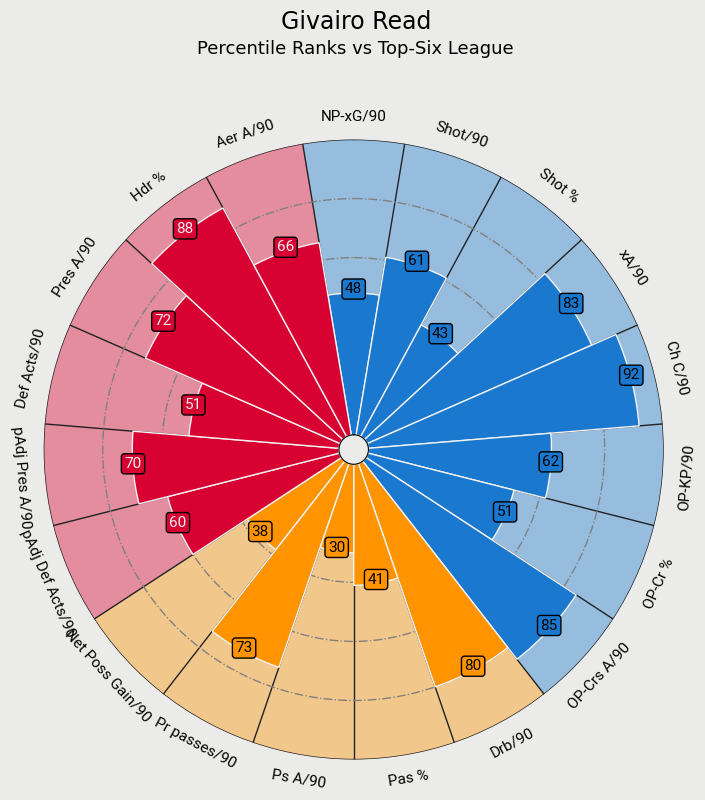

In [226]:
random_player = players.sample(n=1)
player_name = str(random_player['Name'].iloc[0])
create_pizza(player_name, metrics)

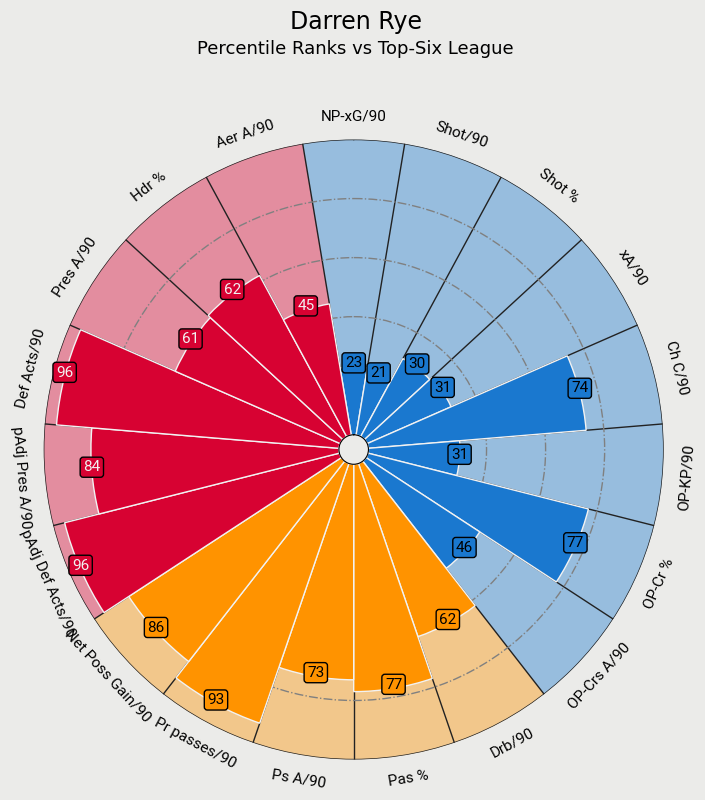

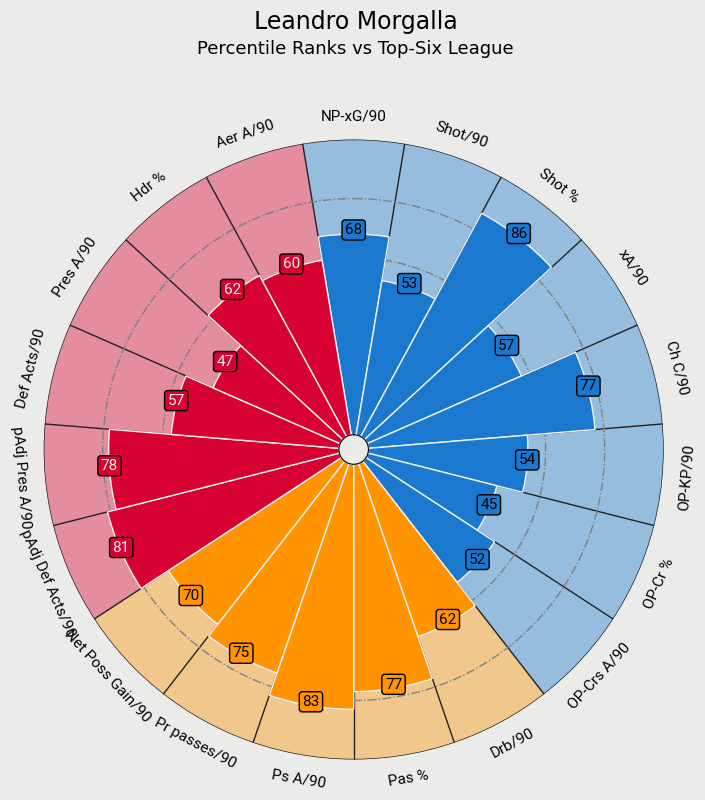

In [227]:
create_pizza('Darren Rye', metrics)
create_pizza('Leandro Morgalla', metrics)

In [176]:
def find_similar_players(df, player_name, metrics, percentile_lower_allowed, threshold=-1):
    """
    """

    assert threshold <= len(metrics)

    if threshold == -1:
        threshold = len(metrics)
    
    player_percentiles = find_percentiles(df, metrics, player_name)
    
    if not len(player_percentiles):
        return []
    
    lower_bound_percentiles = np.maximum(player_percentiles - percentile_lower_allowed, 0)
    lower_bound_stats = []
    for i in range(len(metrics)):
        lower_bound_stats.append(np.percentile(df[metrics[i]], lower_bound_percentiles[i]))

    comparison = df[metrics].ge(lower_bound_stats, axis=1)
    rows_higher_than_reference = df[(comparison.sum(axis=1) >= threshold)]
    
    return rows_higher_than_reference

In [192]:
rb_metrics = [
    'NP-xG/90',
    'xA/90',
    'Ch C/90',
    'OP-KP/90',
    'OP-Cr %',
    'OP-Crs A/90',
    
    'Ps A/90',
    'Pas %',
    'Pr passes/90',
    'Drb/90',
    'pAdj Poss Won/90',
    'Poss Lost/90',
    'Net Poss Gain/90',
    
    'Tck R',
    'pAdj Tck/90',
    'Pres R',
    'pAdj Pres A/90',
    'pAdj Def Acts/90',

    'Aer A/90',
    'Hdr %',
    
    'Dist/90',
    'Sprints/90',
]

percentile_lower_allowed = 15
threshold = 16

sim_players = find_similar_players(
    players, 'Darren Rye', rb_metrics, percentile_lower_allowed, threshold
)

if len(sim_players):
    # some filtering on similar players
    f = sim_players[
        (sim_players['Age'] <= 31) &
        (sim_players['Transfer Value'] <= 75 * 1e9) &
        # (sim_players['Salary'] <= 150 * 1e3)
        (sim_players['Hdr %'] >= 0.45)
    ]
    
    display(f[['Name', 'Age', 'Nat', 'Club', 'Division', 'Mins', 'Av Rat', 'Salary', 'Transfer Value']].sort_values('Transfer Value'))
else:
    print('Player not found')

,Name,Age,Nat,Club,Division,Mins,Av Rat,Salary,Transfer Value
187,Fousseïny Diallo,24,MLI,Liverpool,English Premier Division,710,7.02,70000.0,2.300000e+10
133,Omar El Hilali,29,MAR,Strasbourg,Ligue 1 Uber Eats,1198,6.96,62000.0,2.800000e+10
146,Leandro Morgalla,28,GER,Bournemouth,English Premier Division,1341,6.99,95000.0,3.300000e+10
297,Jurriën Timber,31,NED,Juventus,Italian Serie A,1258,7.07,87000.0,3.500000e+10
135,Justin Che,29,USA,Bayer 04,Bundesliga,584,6.95,80000.0,3.900000e+10
74,Brandon Soppy,30,FRA,Rennes,Ligue 1 Uber Eats,1623,7.01,100000.0,4.300000e+10
249,Amar Dedić,30,BIH,Man City,English Premier Division,880,6.93,220000.0,4.600000e+10
29,Diego Herrero,24,ESP,RB Leipzig,Bundesliga,1612,6.79,61000.0,5.600000e+10
161,Maximilian Wagener,24,GER,Bayer 04,Bundesliga,1640,7.04,64000.0,5.900000e+10
215,David,24,ESP,1. FC Köln,Bundesliga,1350,7.15,61000.0,6.000000e+10


In [228]:
slice_colors = ["#1A78CF"] * 6 + ["#FF9300"] * 7 + ["#D70232"] * 9
text_colors = ["#000000"] * 6 + ["#F2F2F2"] * 16

rb_names = players['Name'].sort_values()
widgets.interact(lambda player_name: create_pizza(player_name, rb_metrics), player_name=rb_names);

interactive(children=(Dropdown(description='player_name', options=('Aaron Hickey', 'Abdul Ullah', 'Adam Bakoun…